In [15]:
%reload_ext autoreload

import os
import sys

import numpy as np
import pandas as pd
import scipy.sparse as sps
import yaml
from itertools import chain, product, combinations
import torch

from time import time as tt
from tqdm import tqdm

from gnn4itk_cf.core.infer_stage import infer
from gnn4itk_cf.core.eval_stage import evaluate

from gnn4itk_cf.stages.data_reading.models.trackml_utils import *

from gnn4itk_cf.stages.data_reading.data_reading_stage import EventReader
from gnn4itk_cf.stages.data_reading.models.trackml_reader import TrackMLReader

from gnn4itk_cf.stages.graph_construction.models.metric_learning import MetricLearning
from gnn4itk_cf.stages.edge_classifier.models.filter import Filter
from gnn4itk_cf.stages.edge_classifier import InteractionGNN

from gnn4itk_cf.stages.graph_construction.utils import handle_weighting
from gnn4itk_cf.stages.graph_construction.models.utils import graph_intersection, build_edges
from gnn4itk_cf.stages.graph_construction.utils import *

from gnn4itk_cf.stages.track_building import utils 
from torch_geometric.utils import to_scipy_sparse_matrix

print(gnn4itk_cf.core.__file__)

/global/homes/a/alazar/acorn/gnn4itk_cf/core/__init__.py


In [5]:
config_dr = "../../examples/Example_1/data_reader.yaml"
config_mm = "../../examples/Example_1/module_map_infer.yaml"
config_gnn = "../../examples/Example_1/gnn_infer.yaml"
config_tbi = "../../examples/Example_1/track_building_infer.yaml"
config_tbe = "../../examples/Example_1/track_building_eval.yaml"

In [10]:
#infer(config_dr )
#infer(config_mm)
#infer(config_gnn)
#infer(config_tbi)
#evaluate(config_tbe,config_gnn['stage_dir']+'artifacts/best.ckpt')

In [7]:
with open("../examples/Example_2/metric_learning_train.yaml", "r") as f:
    config_ml = yaml.load(f, Loader=yaml.FullLoader)
model_ml = MetricLearning(config_ml)
with open("../examples/Example_1/gnn_train.yaml", "r") as f:
    config_gnn = yaml.load(f, Loader=yaml.FullLoader)
model_gnn = InteractionGNN(config_gnn)
config_tb = yaml.safe_load(open("../examples/Example_1/track_building_eval.yaml", "r"))
print(config_gnn['stage_dir']+'artifacts')

/scratch/cf/Example_1/gnn/artifacts


In [9]:
model_ml.setup(stage="predict")
dataloaders = model_ml.predict_dataloader()
model_ml = MetricLearning.load_from_checkpoint(config_ml['stage_dir']+'artifacts/best.ckpt')
model_gnn.setup('predict')
dataloaders = model_gnn.predict_dataloader()
model_gnn = InteractionGNN.load_from_checkpoint(config_gnn['stage_dir']+'artifacts/best-v3.ckpt')

Loaded 80 training events, 10 validation events and 10 testing events


/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pid] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [n_hits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pdg_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [region_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")


/opt/conda/envs/gnn4itk/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../scratch/cf/Example_2/metric_learning/artifacts/best.ckpt`


Defining figures of merit


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Number of reconstructed particles: 14612
Number of particles: 16081
Number of matched tracks: 16260
Number of tracks: 16378
Number of duplicate reconstructed particles: 1640
Efficiency: 0.909
Fake rate: 0.007
Duplication rate: 0.112


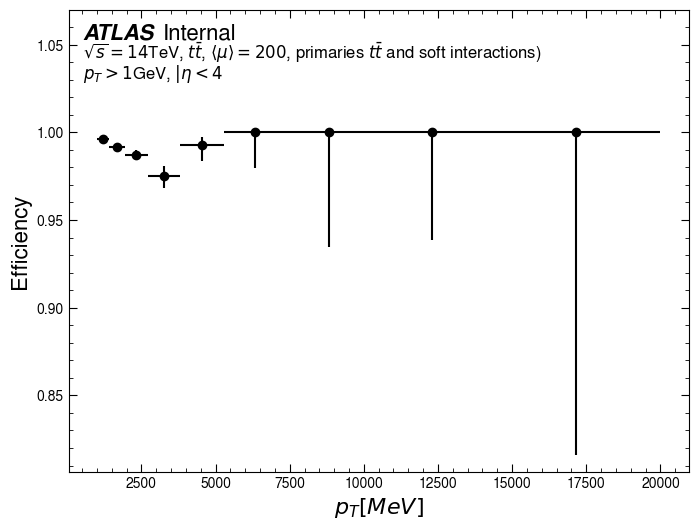

In [11]:
evaluate(config_tbe,config_gnn['stage_dir']+'artifacts/best-v3.ckpt')

In [13]:
def evaluate_labelled_graphs(graphset, config):
    all_y_truth, all_pt  = [], []
    evaluated_events = [
        utils.evaluate_labelled_graph(
            event,
            matching_fraction=config["matching_fraction"],
            matching_style=config["matching_style"],
            min_track_length=config["min_track_length"],
            min_particle_length=config["min_particle_length"],
        )
        for event in tqdm(graphset)
    ]
    evaluated_events = pd.concat(evaluated_events)

    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[particles["is_reconstructed"] & particles["is_matchable"]]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=['event_id', 'particle_id']))
    n_reconstructed_particles = len(reconstructed_particles.drop_duplicates(subset=['event_id', 'particle_id']))

    n_tracks = len(tracks.drop_duplicates(subset=['event_id', 'track_id']))
    n_matched_tracks = len(matched_tracks.drop_duplicates(subset=['event_id', 'track_id']))

    n_dup_reconstructed_particles = len(reconstructed_particles) - n_reconstructed_particles

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   

    # Plot the results across pT and eta
    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    logging.info(f"Efficiency: {eff:.3f}")
    logging.info(f"Fake rate: {fake_rate:.3f}")
    logging.info(f"Duplication rate: {dup_rate:.3f}")
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

In [16]:
device ='cuda'
model_ml = model_ml.to("cuda")
model_gnn = model_gnn.to("cuda")
graphs = []
for batch_idx, batch in enumerate(dataloaders[2]):
    batch = batch.to("cuda")    
    gnn = model_gnn.shared_evaluation(batch,batch_idx)
    batch = gnn['batch']

    edge_mask = gnn['output'] > model_gnn.hparams['edge_cut'] 
    # Get number of nodes
    if hasattr(batch, "num_nodes"):
        num_nodes = batch.num_nodes
    elif hasattr(batch, "x"):
        num_nodes = batch.x.size(0)
    elif hasattr(batch, "x_x"):
        num_nodes = batch.x_x.size(0)
    else:
        num_nodes = batch.edge_index.max().item() + 1
    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        batch.edge_index[:, edge_mask], num_nodes=num_nodes
    )
    # Run connected components
    candidate_labels = sps.csgraph.connected_components(
        sparse_edges, directed=False, return_labels=True
    )
    batch.labels = torch.from_numpy(candidate_labels[1]).long()
    graphs.append(batch.to('cpu'))
evaluate_labelled_graphs(graphs, config_tb)

100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Number of reconstructed particles: 12046
Number of particles: 16081
Number of matched tracks: 12398
Number of tracks: 13201
Number of duplicate reconstructed particles: 344
Efficiency: 0.749
Fake rate: 0.061
Duplication rate: 0.029
